In [1]:
import numpy as np
import skimage as ski
from skimage import data
from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy.ndimage import convolve

In [2]:
def padimg(im,fshape):
    er=int(fshape[0]/2)
    ec=int(fshape[1]/2)
    ans=np.zeros(((er*2)+im.shape[0],(ec*2)+im.shape[1]))
    ans[er:er+im.shape[0],ec:ec+im.shape[1]]=im
    return ans,er,ec

def applyfilter(im,ifilter):
    pimg,er,ec=padimg(im,ifilter.shape)
    ans=np.zeros_like(im)
    ans=ans.astype(np.float64)
    for i in np.arange(er,er+im.shape[0]):
        for j in np.arange(ec,ec+im.shape[1]):
            w=pimg[i-er:i+er+1,j-ec:j+ec+1]
            ans[i-er,j-ec]=np.sum(ifilter*w)
    return ans

def gFilter(sigma,stepsize=1):
    l=np.arange(-2*sigma,(2*sigma)+1,stepsize)
    x,y=np.meshgrid(l,l)
    ans=(x**2)+(y**2)
    ans=ans/(2.0*(sigma**2))
    ans=np.exp(-ans)
    ans=ans/(2.0*np.pi*(sigma**2))
    ans=np.array(ans)
    #print ans.shape[0]
    return ans,x,y

In [3]:
# def formsmoothingfilter(sigma=3):
# #     d1=np.ones((3,1))
#     d1=np.array([1,2,1]).reshape(3,1)
#     d2=np.array([-1,0,1]).reshape(1,3)
#     diffx=np.dot(d1,d2)
#     diffx=np.flip(np.flip(diffx,0),1)
#     diffx=np.flip(np.flip(diffx,0),0)
#     gauss,x,y=gFilter(sigma)
# #     gx=applyfilter(gauss,diffx)
# #     gy=applyfilter(gauss,diffx.T)
#     gx=convolve(gauss,diffx)
#     gy=convolve(gauss,diffx.T)
#     return gy,gx



# def EdgeEnhance(im,sgfy,sgfx):
# #     dy=applyfilter(im,sgfy)
# #     dx=applyfilter(im,sgfx)
#     sgfy=np.flip(np.flip(sgfy,0),1)
#     sgfx=np.flip(np.flip(sgfx,0),1)
#     dx = convolve(im,sgfx)
#     dy = convolve(im, sgfy)
#     mag=(dy**2) + (dx**2)
#     mag=np.sqrt((mag))
#     c=dx.copy()
#     c[c==0]=1
#     dr=dy.astype(np.float32)/c.astype(np.float32)
#     dr=np.arctan(dr.astype(np.float32)).astype(np.float32)
#     dr[dx==0]=np.pi/2
#     return mag,dr





In [4]:
def smoothderivateimage(im,gaussfilter):
    smimage=applyfilter(im,gaussfilter)
    d1=np.array([1,2,1]).reshape(3,1)
    d2=np.array([-1,0,1]).reshape(1,3)
    diffmat=np.dot(d1,d2)
    gx=applyfilter(smimage,diffmat)
    gy=applyfilter(smimage,diffmat.T)
    gr=(gy**2) + (gx**2)
    gr=np.sqrt((gr)).astype(np.uint8)   
    c=gx.copy()
    c[c==0]=1
    dr=gy.astype(np.float32)/c.astype(np.float32)
    dr=np.arctan(dr.astype(np.float32)).astype(np.float32)
    #dr[gx==0]=np.pi/2
    return gr,dr



In [5]:
def quantizedirections(dr,edgedir=4):
    return (np.round(dr/((np.pi)/edgedir))%edgedir)

def suppress(mag,dr):
    ans=mag.copy();
    inds=np.array([1,0,1,1,0,1,-1,1]).reshape(4,2)#indexes that are added or subtracted 
    #print inds
    for i in np.arange(0,mag.shape[0]):
        for j in np.arange(0,mag.shape[1]):
            intendeddirection=dr[i,j].astype(np.int)
            n1r=max(0,min(mag.shape[0]-1,i+inds[intendeddirection][0]))
            n1c=max(0,min(mag.shape[1]-1,j+inds[intendeddirection][1]))
            n2r=max(0,min(mag.shape[0]-1,i-inds[intendeddirection][0]))
            n2c=max(0,min(mag.shape[1]-1,j-inds[intendeddirection][1]))
            if(mag[n1r,n1c]>mag[i,j] or mag[n2r,n2c]>mag[i,j] ):
                ans[i,j]=0         
        
    return ans
            

In [6]:
def thresh(highthresh,lowthresh,mag):
    hi=mag>highthresh
    li=mag>lowthresh
    li=li-hi
    ans=hi.copy()
    for i in np.arange(0,mag.shape[0]):
        for j in np.arange(0,mag.shape[1]):
            if(ans[i,j]==0):
                rs=max(0,i-1)
                re=min(mag.shape[0],i+2)
                cs=max(0,j-1)
                ce=min(mag.shape[1],j+2)
                w=hi[rs:re,cs:ce]==1
                if(w.any()):
                    ans[i,j]=1
    return ans
def applycaddy(im,gauss):
    mag,dr=smoothderivateimage(im,gauss)
    drnew=quantizedirections(dr).astype(np.int)
    supimage=suppress(mag,drnew)
        #plt.imshow(supimage.astype(np.uint8),cmap='gray')
    highthresh=np.max(supimage)*0.15
    lowthresh=np.max(supimage)*0.7
    final=thresh(highthresh,lowthresh,supimage)
    final[0:7,:]=0
    final[-7:,:]=0
    final[:,0:7]=0
    final[:,-7:]=0
    return final



In [7]:
def drawlineonimage(im,thetas,rs,numparams):
    im=im.copy()
    for ind in np.arange(0,numparams):
        if (thetas[ind]==0):
            im[:,int(rs[ind])]=255
        elif(thetas[ind]==np.pi):
            im[rs[ind],:]=255
        else:
            for j in np.arange(0,im.shape[1]):
                i=int((rs[ind]-(j*np.cos(thetas[ind])))/np.sin(thetas[ind]))
                if(i >=0 and i<im.shape[0] ):
                    im[i,j]=255
#             for i in np.arange(0,im.shape[0]):
#                 j=int((rs[ind]-(i*np.sin(thetas[ind])))/np.cos(thetas[ind]))
#                 if(j >=0 and j<im.shape[1] ):
#                     im[i,j]=255       
                
    return im

In [8]:
def hough(edimage,startTheta=-90,endTheta=90,thetainc=1,rinc=1):
    nthetas=(int(endTheta-startTheta)/thetainc)+1
    thetas=np.linspace(startTheta,endTheta,nthetas,dtype=np.float32)
    
    maxr=(np.array(edimage.shape)-1)**2
    maxr=np.sqrt(sum(maxr))
    numr=int(2*np.ceil(maxr))+1
    rs=np.linspace(-maxr,maxr,numr)
    degRadRatio=np.pi/180
    accarray=np.zeros((thetas.size,rs.size))
    for i in np.arange(0,edimage.shape[0]):
        for j in np.arange(0,edimage.shape[1]):
            if (edimage[i,j]):
                for t in np.arange(0,thetas.size):
                    rval=(j*np.cos(thetas[t]*degRadRatio))+(i*np.sin(thetas[t]*degRadRatio))
                    roidx=np.argmin(np.abs(rs-rval))
                    accarray[t,roidx]+=1
    return thetas,rs,accarray
    #houghmatrix has been formed

        
def houghPeaks(thetas,rds,accarray,nvotes=2):
    count=0
    ans=np.zeros((nvotes,2))
    while(count<nvotes):
        r,c=np.unravel_index(accarray.argmax(), accarray.shape)
#         print (r)
#         print (c)
        ans[count][0]=thetas[r]
        ans[count][1]=rds[c]
        
        rowstart=max(0,r-1)
        rowend=min(accarray.shape[0],r+2)
        columnstart=max(0,c-1)
        columnend=min(accarray.shape[1],c+2)
        accarray[rowstart:rowend,columnstart:columnend]=0
        count+=1
    return ans

In [9]:
def find_best_line(peaks,imhypt,twidth=10,rwidth=2):
    thetamin=-90
    thetamax=89
    twidth=10
    tbins=int(((thetamax-thetamin)+1)/twidth)
    
    hyptmin=-imhypt
    hyptmax=imhypt
    rwidth=2
    rbins=int(((hyptmax-hyptmin)+1)/rwidth)
    
    ans=np.zeros((tbins,rbins),dtype=np.int64)

    for i in np.arange(0,peaks.shape[0]):
        theta=int((peaks[i,0]-thetamin)/twidth)
        rs=int((peaks[i,1]-hyptmin)/rwidth)
        if (theta>=0 and theta<tbins and rs>0 and rs<rbins):
            ans[theta,rs]+=1
    r,c=np.unravel_index(ans.argmax(), ans.shape)  
    ft=((r*twidth)+thetamin)+(twidth/2)
    r=((c*rwidth)+hyptmin)+(rwidth/2)
    return ft,r

In [10]:
def detectanddrawlines(ims,thetaranges,gauss,numimgs):
    figure,axis=plt.subplots(numimgs,1,figsize=(20,20))
    degRadRatio=np.pi/180

    for i in np.arange(0,numimgs):
        edgeimage=applycaddy(ims[i],gauss)
#         maxt,rs=hough(3,edgeimage,thetaranges[i,0],thetaranges[i,1])
        thetas,rs,accarray=hough(edgeimage,thetaranges[i,0],thetaranges[i,1])
        peaks=houghPeaks(thetas,rs,accarray,5)
        
        maxr=(np.array(edgeimage.shape)-1)**2
        maxr=np.sqrt(sum(maxr))
        theta,r=find_best_line(peaks,maxr)
#         finalimage=drawlineonimage(ims[i],maxt,rs,maxt.size)

#         finalimage=drawlineonimage(ims[i],peaks[:,0]*degRadRatio,peaks[:,1],peaks.shape[0])
#         finalimage=drawlineonimage(ims[i],np.array([theta])*degRadRatio,np.array([r]),peaks.shape[0])
        finalimage=drawlineonimage(ims[i],np.array([theta])*degRadRatio,np.array([r]),1)
        axis[i].imshow(finalimage,cmap='gray')
        
        

In [11]:
q=np.array([5,6,7])
print q

[5 6 7]


/home/armughan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  after removing the cwd from sys.path.


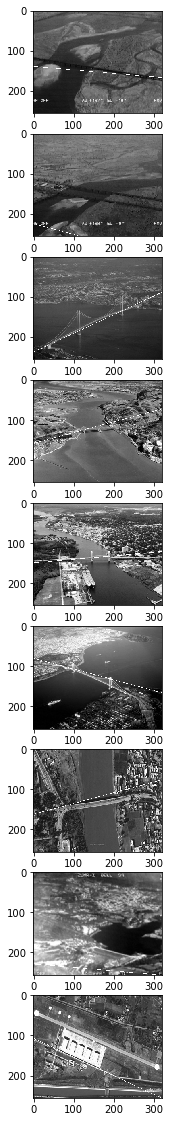

In [12]:
ims=io.imread_collection("./test images/*")
numimgs=len(ims)

a=[[-90,-45],[-80,-45],[30,90],[70,90],[70,90],[-80,-30],[70,90],[-90,-50],[-70,-50]]
thetaranges=np.zeros((9,2))+a

gauss,x,y=gFilter(3)
detectanddrawlines(ims,thetaranges,gauss,numimgs)